# GWAS Lab

In this lab we will be running a GWAS with data from *Arabidopsis thaliana*.

## The Data

The data for this lab comes from [The 1001 Genomes Project](https://1001genomes.org/), specifically the [EasyGWAS website](https://easygwas.biochem.mpg.de/down/1/). 

The genomic data are in three files in /mnt/research/PLB_812_FS25_S001/08_GWAS_Josephs/

`arabidopsis.bed` has the genotypes for every individual in the dataset. <br>
`arabidopsis.bim` has the locations of every SNP in `arabidopsis.bed` <br>
`arabidopsis.fam` tells you the order of the genotypes in the file.

The phenotypic data is in `phenotypes.pheno`.


## Installing GEMMA

We will be using the software [GEMMA](https://github.com/genetics-statistics/GEMMA) to run the GWAS. The HPCC does not maintain GEMMA, but it is pretty easy to get running on your own. 

First, use wget to download GEMMA. I find it easiest to make an "Apps" folder in my home directory on the HPCC that I use to keep the programs I download, but it doesn't actually matter where you download this file.

`$ wget https://github.com/genetics-statistics/GEMMA/releases/download/v0.98.5/gemma-0.98.5-linux-static-AMD64.gz`

Next, use gunzip to uncompress the file.

`$ gunzip gemma-0.98.5-linux-static-AMD64.gz`

Use chmod to make this file executable. 

`$chmod u+x gemma-0.98.5-linux-static-AMD64`

Now, run the file to check to see what happens

`$ ./gemma-0.98.5-linux-static-AMD64`

If everything is working right you should get an introductory message about the program.

## Running a simple GWAS

### Making the phenotype file (Emily has already done this for you so you don't need to run the code below, but I left the code here in case you need it).

We need to add our phenotypes to the **.fam** file. We'll be looking at the trait **DTF1** which describes days until bolting. This is an important reproductive trait. This is the fourth trait in the phenotype file **phenotypes.pheno**.

First, rename the `arabidopsis.fam` file so you have it for later.

`$mv arabidopsis.fam arabidopsis-old.fam`

Below is some code to do this. Note that you will need to change the paths to the fam, pheno, and out files.


In [2]:
#open the files
famFile = open("/mnt/ufs18/rs-039/PLB_812_F25_001/08_GWAS/arabidopsis.fam",'r')
phenoFile = open("/mnt/ufs18/rs-039/PLB_812_F25_001/08_GWAS/phenotypes.pheno",'r')

#make a dictionary for the phenotype data
phenoDict = {}

#read in the phenotype data
phenos = phenoFile.readlines()
for phen in phenos:
    p = str.split(phen)
    dtf=p[8]
    if (dtf=='nan'):
        dtf="-9"
    #change the NA strings
    #add to the dictionary where key is the genotype and the value is the phenotype
    phenoDict[p[1]]= dtf
phenoFile.close()

#open the output file
outFile = open("/mnt/ufs18/rs-039/PLB_812_F25_001/Users/zalesk34/08_GWAS/arabidopsis.fam","w")

#read in the genotype file -- we want our output to be in this order!
genos = famFile.readlines()
for geno in genos:
    g = str.split(geno)
    #make the output line from the genotype file plus the phenotype
    newg = [*g[0:5],phenoDict[g[1]],'\n']
    myout = '    '.join(newg)
    outFile.write(myout)

#close all the files
famFile.close()
outFile.close()

### Running the GWAS

Here is the code for running the GWAS.

`../../Apps/gemma-0.98.5-linux-static-AMD64 -bfile arabidopsis -lm 2 -n 1 -o dtf`

You can read the manual for all the options, but note that the **-lm** flag sets the type of model to run, and the **-n** flag tells you which phenotype to use if the **.fam** file has multiple phenotypes.

I'm not sure if HPCC will handle the whole class running GEMMA on the same development node at the same time, so you may want to put this code into a bash script and submit it to slurm. As a reminder, here is a guide to do this: https://docs.icer.msu.edu/Job_Script_and_Job_Submission/. Also, keep in mind that you can edit bash script files in ondemand. Alternatively, you can start an interactive job in the slurm system with salloc using this guide: https://docs.icer.msu.edu/Interactive_Job/


## Looking at the data

Gemma will make a folder called "output" wherever you are when you run the command, and stick all of its outputs there. Inside that folder, you'll find something called **dtf.assoc.txt** (note that if you'd used a different string of letters after the -o flag in your gemma code you'd get a different file name).

You can use **less** or another program to look at this file. It's a flat file with a line for each SNP. The top row tells you what each column contains. You could use R or another tool to parse through this data. However, it might be more fun to make a manhattan plot.

I wrote a short R script to make a manhattan plot of the data.

`$module load R-bundle-CRAN/2023.12-foss-2023a`

`$Rscript --vanilla manplot.R [path to gemma output] [output file name]`

or use manplot-pdf.R to make a pdf instead of an eps file

The R script makes a manhattan plot and a qq plot in an .eps or .pdf format. Download these plots and investigate them. 

## Running a mixed model GWAS

Next, we will run a mixed model GWAS that accounts for relatedness between the Arabidopsis samples.


### Making a kinship matrix

This command makes a kinship matrix.

`$../../Apps/gemma-0.98.5-linux-static-AMD64 -bfile arabidopsis -gk 2 -o arabidopsis`

the **-gk** flag tells GEMMA that we want to make a standardized kinship matrix (instead of a centered one). You can read more in the manual about the distinction between these two options.

### Running the GWAS

This is the command for running the GWAS with our new kinship matrix. 

`$../../Apps/gemma-0.98.5-linux-static-AMD64 -bfile arabidopsis -k output/arabidopsis.sXX.txt -lmm 2 -n 1 -o dtf-mixed`

We can make more plots with the R script.

`$Rscript --vanilla manplot.R [path to gemma output] [output file name]`



### Questions 

1) Please add both of your manhattan plots and both of your qq plots to the ipython notebook that you submit.
Simple:
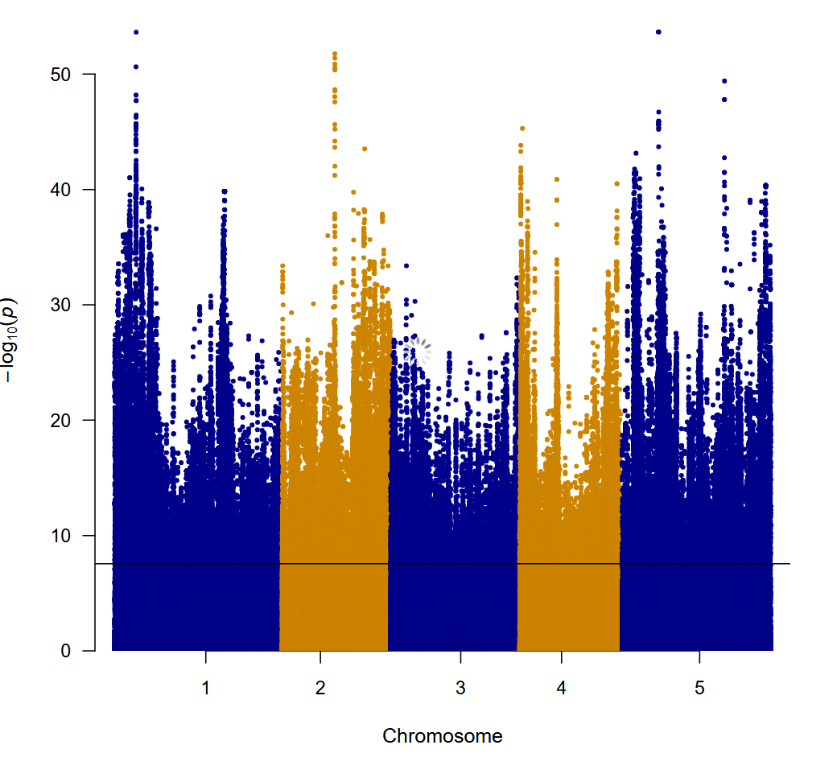
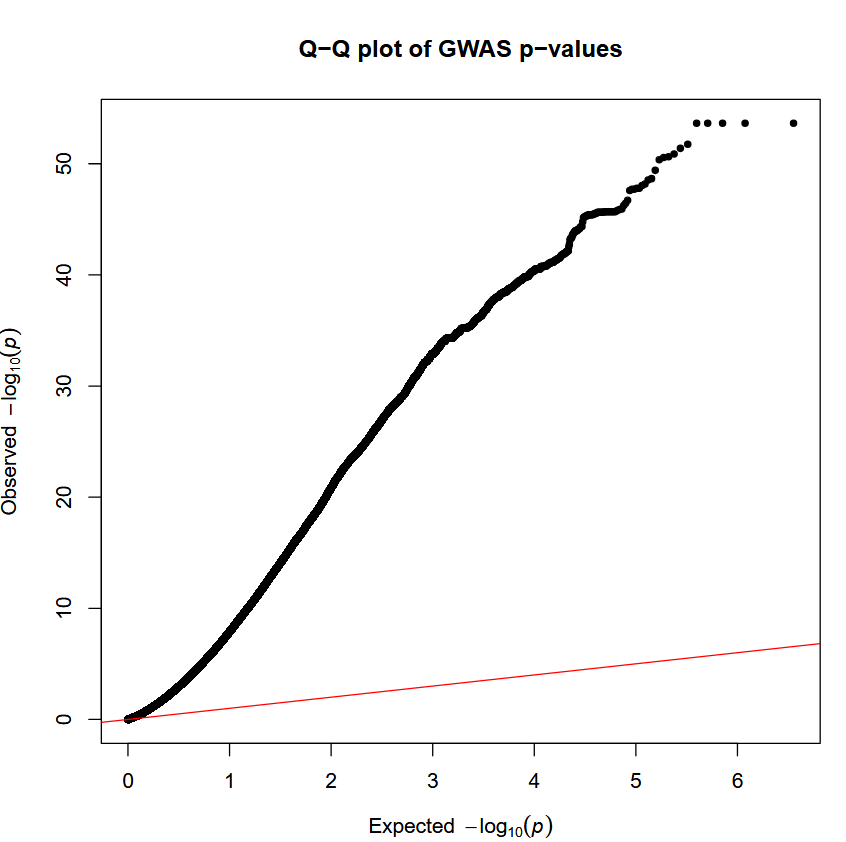
Mixed Model:
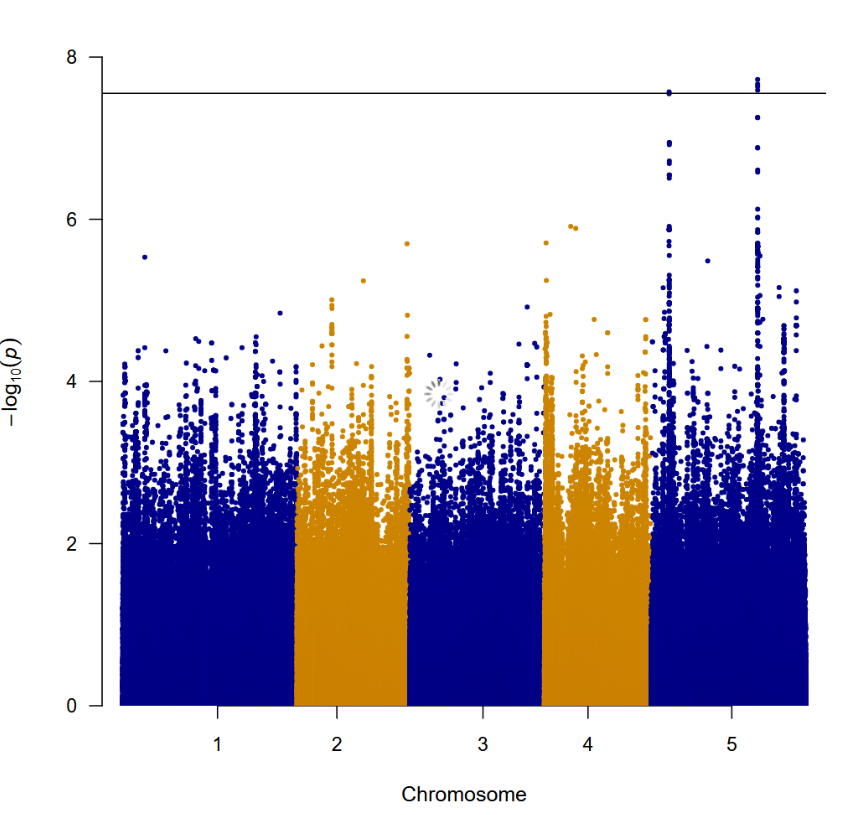
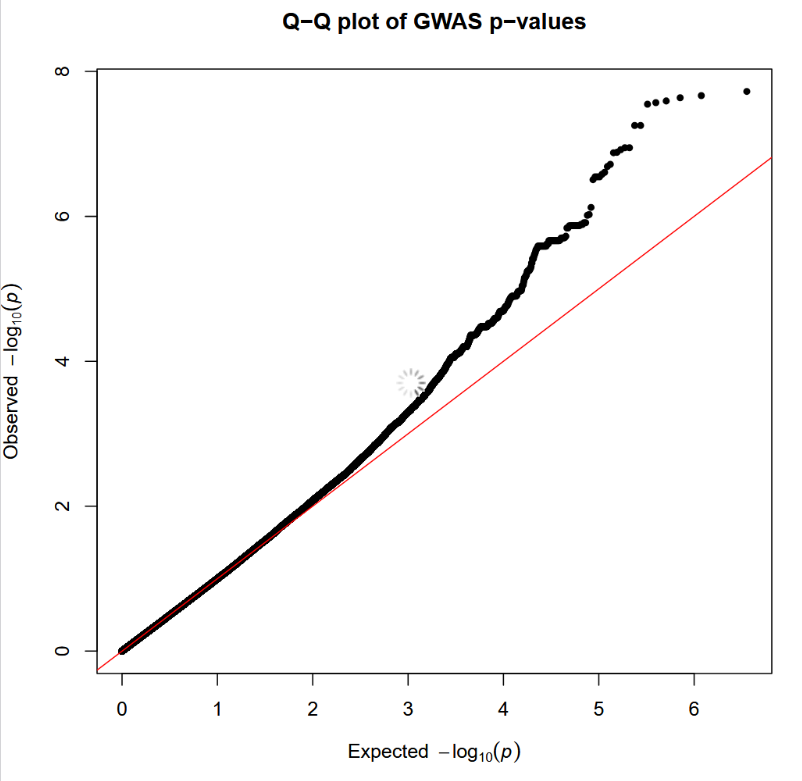
3) How do the Manhattan plots of the simple GWAS and the mixed model GWAS differ?
   The manhattan plots are very different. In the simple GWAS, almost all loci were considered significant. In the mixed model GWAS, with kinship accounted for, there were only a small handful. 
4) How do the QQ Plots of the simple GWAS and the mixed model GWAS differ?
The QQ plots were also enitrely different. The simple qq plot immediately differed from the expected line, suggesting associations at pretty well all loci. The mixed model qq plot followed the expected line until abut half way when it started to drift up. There are still quite a few dots that deviate from the line but it is much more reasonable than the association inflation you can see with the plots form the simple GWAS.